In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
from torch import nn
import seaborn as sns
import pandas as pd
import os
import pathlib
import shutil
import cv2
import PIL

TEXT_COLOR = 'black'

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
PROJECT_ROOT = pathlib.Path('D:/d_tsw/1_SIGN_CLASSIFIER') #pathlib.Path(os.path.join(os.curdir, os.pardir))
ROOT_DIR = PROJECT_ROOT / 'data/rtsd-r3'
train_dir_source = ROOT_DIR / 'train'
train_dir = ROOT_DIR / 'train'

In [3]:
gt_train = pd.read_csv(ROOT_DIR / 'gt_train.csv')
numbers_to_classes = pd.read_csv(ROOT_DIR / 'numbers_to_classes.csv')

gt_train = pd.merge(gt_train, numbers_to_classes, on='class_number', how='left', validate='many_to_one', copy=False)
gt_train.drop(['class_number'], inplace=True, axis=1)
gt_train['IsPresent'] = pd.Series([1 for x in range(len(gt_train.index))])

del numbers_to_classes

,filename,sign_class,IsPresent
0,000000.png,2_1,1
1,000001.png,2_1,1
2,000002.png,2_1,1
3,000003.png,2_1,1
4,000004.png,1_23,1
...,...,...,...
71012,071007.png,3_22,1
71013,071008.png,3_22,1
71014,071009.png,3_22,1
71015,071010.png,3_22,1


{"5_19_1":19913,"2_1":8620,"5_16":3751,"5_15_2":3544,"3_27":2409,"1_23":2320,"5_20":1841,"3_24_n40":1804,"4_1_1":1673,"1_17":1145,"3_20":1036,"5_5":915,"5_15_1":873,"4_1_4":871,"3_1":868,"4_2_3":828,"1_25":802,"6_4":794,"7_3":790,"5_15_2_2":700,"3_24_n20":696,"4_2_1":693,"6_6":662,"5_15_3":619,"1_22":603,"2_3_2":593,"5_15_5":559,"2_5":512,"2_2":479,"3_4_1":476,"5_6":474,"4_2_2":433,"2_3_3":400,"4_1_2":359,"1_20_2":319,"7_5":312,"1_2":301,"1_11_1":298,"3_28":294,"5_14":251,"1_11":249,"1_16":235,"3_18":219,"1_1":198,"3_24_n50":193,"2_3":191,"3_18_2":169,"6_3_1":156,"5_15_7":152,"4_3":149,"3_24_n5":149,"5_7_2":141,"4_1_5":139,"4_1_2_1":135,"3_24_n30":131,"7_2":129,"1_12_2":128,"1_15":126,"3_13_r4.5":124,"1_8":120,"5_7_1":119,"4_1_2_2":119,"3_24_n60":117,"7_11":111,"3_24_n80":111,"3_2":110,"7_4":110,"7_7":101,"1_21":93,"5_3":91,"5_11":85,"7_12":84,"2_6":83,"2_4":83,"1_33":82,"6_7":80,"3_24_n70":80,"3_22":80,"1_12":79,"1_20_3":76,"1_5":72,"4_1_6":68,"6_2_n50":59,"3_24_n120":57,"3_32":54,"5_

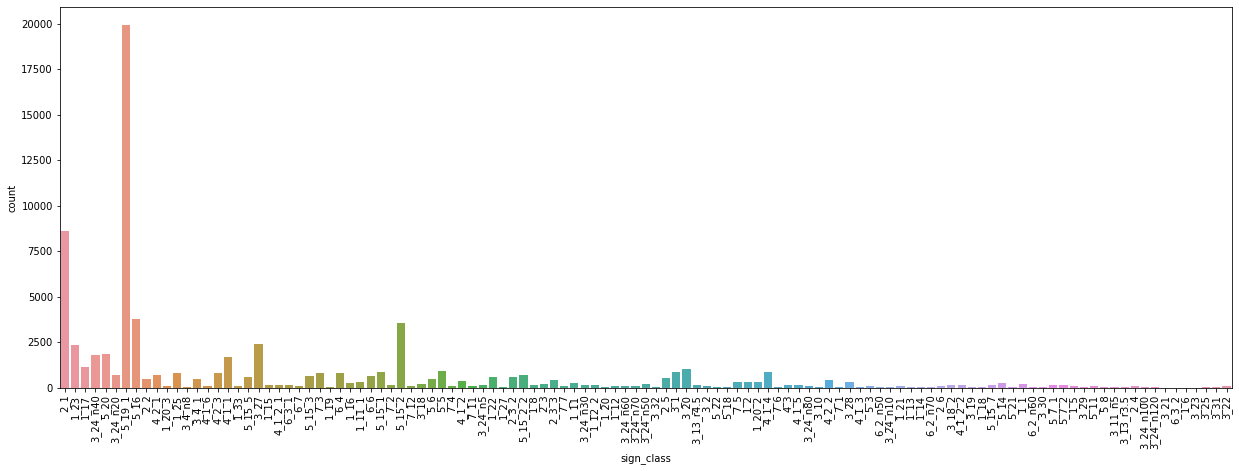

In [4]:
display(gt_train)
print(gt_train['sign_class'].value_counts().to_json())
_, ax = plt.subplots(figsize=(21, 7))
plt.xticks(rotation=90)
sns.countplot(x='sign_class', data=gt_train, ax=ax);

In [5]:
EXTRACT_BIG = True
EXTRACT_SPECIFIC_CLASSES = True

if EXTRACT_SPECIFIC_CLASSES == False:
    CLASSES = gt_train['sign_class'].values
    print("[!] Assume classification for all of available classes")
    
else:
    CLASSES = [
        '1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', 
        # ~2_3_1
        '2_3', \
        # /~2_3_1
        '2_4', '2_5', '3_1', 
        # ~3_18_1
        '3_18', 
        # /~3_18_1
        '3_20', '3_21', '3_22', '3_23', \
        # all speed limits
        '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', \
        '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', \
        # /all speed limits
        '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', 
        '5_19_1',  
        #'5_19_2', \ ~ '5_19_1'
        '5_20', '6_3_2', '6_4', '7_3', '7_4'
    ]
    print("[+] Classification for all of those classes:\n", CLASSES)

def printProgressEnum(index, length, label=None):
    print('\r{}Progress: {}/{} ({:.2f}%)'.
                  format(label if label != None else '', index + 1, length, 100 * (index + 1) / length), flush=True, end='')

def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_train.iloc[index]['sign_class']
    if path:
        return gt_train[gt_train['filename']==str(path).split(sep='\\')[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_train[gt_train['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

if EXTRACT_BIG == True:
    list_of_origin_train_images = os.listdir(train_dir_source)
  
    included_clases = set()
    
    gt_train_size = len(gt_train.index)
    
    for index, row in gt_train.iterrows():

        full_path_to_image = train_dir_source / row['filename']
        
        class_for_current_image = row['sign_class']
                
        if class_for_current_image in CLASSES:
          included_clases.add(class_for_current_image)
          # shutil.copy2(full_path_to_image, train_dir)
        else:
          gt_train.loc[index, 'IsPresent'] = 0
          # print('\n[!]', class_for_current_image, 'is not CLASSES')

        
        if (index % 100 == 0) or (index + 1 == gt_train_size):
            printProgressEnum(index, gt_train_size)
    
    not_included_signs = set(CLASSES) - included_clases
    if not_included_signs:
        print('\n[!] These signs were not included: \n', not_included_signs)
        
list_of_big_train_images = os.listdir(train_dir)

[+] Classification for all of those classes:
 ['1_1', '1_6', '1_8', '1_22', '1_31', '1_33', '2_1', '2_2', '2_3', '2_4', '2_5', '3_1', '3_18', '3_20', '3_21', '3_22', '3_23', '3_24_n10', '3_24_n20', '3_24_n30', '3_24_n40', '3_24_n50', '3_24_n60', '3_24_n70', '3_24_n80', '3_24_n90', '3_24_n100', '3_24_n110', '3_24_n120', '3_24_n130', '3_25', '3_27', '3_28', '3_31', '4_1_1', '4_3', '5_5', '5_6', '5_16', '5_19_1', '5_20', '6_3_2', '6_4', '7_3', '7_4']
Progress: 71017/71017 (100.00%)
[!] These signs were not included: 
 {'3_24_n130', '3_24_n90', '3_24_n110', '1_31'}


In [6]:
print(gt_train.loc[gt_train['IsPresent'] == 1]['sign_class'].value_counts())
print(np.mean(gt_train.loc[gt_train['IsPresent'] == 1]['sign_class'].value_counts()))

5_19_1       19913
2_1           8620
5_16          3751
3_27          2409
5_20          1841
3_24_n40      1804
4_1_1         1673
3_20          1036
5_5            915
3_1            868
6_4            794
7_3            790
3_24_n20       696
1_22           603
2_5            512
2_2            479
5_6            474
3_28           294
3_18           219
1_1            198
3_24_n50       193
2_3            191
4_3            149
3_24_n30       131
1_8            120
3_24_n60       117
3_24_n80       111
7_4            110
2_4             83
1_33            82
3_24_n70        80
3_22            80
3_24_n120       57
3_24_n100       41
3_25            19
3_24_n10         9
3_31             8
3_23             7
3_21             3
6_3_2            1
1_6              1
Name: sign_class, dtype: int64
1206.878048780488


In [7]:
MODEL_CLASSES = sorted(list(included_clases))
MODEL_CLASSES

from sklearn import preprocessing
MODEL_LABEL_ENCODER = preprocessing.LabelEncoder()
MODEL_CLASSES_TARGETS = MODEL_LABEL_ENCODER.fit_transform(MODEL_CLASSES)

MODEL_CLASS_MAP = dict(zip(MODEL_CLASSES, MODEL_CLASSES_TARGETS))
MODEL_CLASS_MAP

{'1_1': 0,
 '1_22': 1,
 '1_33': 2,
 '1_6': 3,
 '1_8': 4,
 '2_1': 5,
 '2_2': 6,
 '2_3': 7,
 '2_4': 8,
 '2_5': 9,
 '3_1': 10,
 '3_18': 11,
 '3_20': 12,
 '3_21': 13,
 '3_22': 14,
 '3_23': 15,
 '3_24_n10': 16,
 '3_24_n100': 17,
 '3_24_n120': 18,
 '3_24_n20': 19,
 '3_24_n30': 20,
 '3_24_n40': 21,
 '3_24_n50': 22,
 '3_24_n60': 23,
 '3_24_n70': 24,
 '3_24_n80': 25,
 '3_25': 26,
 '3_27': 27,
 '3_28': 28,
 '3_31': 29,
 '4_1_1': 30,
 '4_3': 31,
 '5_16': 32,
 '5_19_1': 33,
 '5_20': 34,
 '5_5': 35,
 '5_6': 36,
 '6_3_2': 37,
 '6_4': 38,
 '7_3': 39,
 '7_4': 40}

In [8]:
def getPictureSignClass(filename=None, path=None, index=None):
    if index:
        return gt_train.iloc[index]['sign_class']
    if path:
      return gt_train[gt_train['filename']==pathlib.Path(path).parts[-1]]['sign_class'].values[0]
    else:
        if filename:
            return gt_train[gt_train['filename']==filename]['sign_class'].values[0]
        else:
            assert False, 'wrong arg'

def getRandomPictureFromTrain():
    # instance = gt_train.sample(1)   # fix me or kill me
    while(1):
        instance = gt_train.sample(axis=0)
        # print(instance['IsPresent'].values)
        if instance['IsPresent'].values == 1:
            instance = instance['filename'].values[0]
            break
        
    # print('!', instance)
    path = pathlib.Path(train_dir / instance)
    # print(path)
    return path, getPictureSignClass(path=path)

def showPictureAndClass(path=None, gt_train_index=None):
    if path != None:
        pass
    else:
        if gt_train_index == None:
            assert False, 'cannot identify picture'
        else:
            path = train_dir / gt_train.iloc[gt_train_index]['filename']
    
    sign_class = str(getPictureSignClass(path=path))
    
    fig = plt.figure(figsize=(4, 4))
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.imshow(img)
    plt.title(f'Label: {sign_class}')
    plt.show()           

D:\d_tsw\1_SIGN_CLASSIFIER\data\rtsd-r3\train\034646.png 3_24_n40


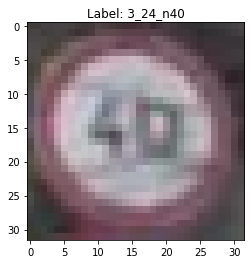

3_24_n40


In [9]:
path, class_ = getRandomPictureFromTrain()
print(path, class_)
showPictureAndClass(path)
print(getPictureSignClass(path=path))

In [10]:
class SignDataset(torch.utils.data.Dataset):
    def __init__(self, df, dir):
        self.df = df[df['IsPresent'] == 1]
        self.dir = dir
    def __len__(self):
        return len(self.df.index)
    
    def __getitem__(self, index):
        label = self.df.iloc[index]['sign_class']
        path = self.dir / self.df.iloc[index]['filename']
        # print(path)
        img = cv2.imread(str(path))
        img = cv2.resize(img, (160, 160))
        # print(img)
        img_tnsr = torch.Tensor.permute(torch.Tensor(img), [2, 0, 1]).div(255)
        # print(label)
        encoded_label = MODEL_CLASS_MAP[label]
        # print(encoded_label)
        return img_tnsr, encoded_label

In [11]:
batch_size_ = 64
train_loader = torch.utils.data.DataLoader(
         SignDataset(gt_train, train_dir),
        batch_size=batch_size_,
        # pin_memory=True,
        shuffle=True,
    )
# next(iter(train_loader))

In [12]:
from torchvision import models, transforms as transforms
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, len(MODEL_CLASSES))
model.to(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(244),
        #transforms.RandomResizedCrop(input_size),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(244),
        #transforms.Resize(input_size),
        #transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [13]:
def train_epoch(model, loader, loss_op, optim):
    loss_ = []
    torch.set_grad_enabled(True)
    
    # Таким образом переводим модель в режим обучения
    # В этом режиме вычисляются градиенты, нужные для обучения
    model.train()
    
    for batch_idx, (imgs_batch, labels_batch) in enumerate(loader):
        # print(imgs_batch.shape)
        imgs_batch = imgs_batch.to(device)
        # print(labels_batch)
        labels_batch = labels_batch.to(device)

        pred = model(imgs_batch)

        loss = loss_op(pred, labels_batch)
        # Сохраним в историю эпохи
        l_ = loss.item()
        loss_.append(l_)
        # model.addValidHistoryAcc(l_)
        # optim.zero_grad()
        for param in model.parameters(): # https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
            param.grad = None
        loss.backward()
        optim.step()
        
        if batch_idx % 20 == 0:
            print('\rTrain Epoch: {} [{}/{} ({:.2f}%)]'.
                  format(epoch, batch_idx * len(imgs_batch), len(loader.dataset),
                 100 * batch_idx * len(imgs_batch) / len(loader.dataset)), flush=True, end='')
        
    print('\rTrain Epoch: {} [{}/{} (100%)]     \n'.
                  format(epoch, len(loader.dataset), len(loader.dataset)), flush=True, end='')
    
    return np.mean(loss_)


from sklearn.metrics import accuracy_score

def evaluate_batch_accuracy(y_pred, y_true):
    '''
    Оценка точности предсказания (accuracy)

    y_pred:
        батч сырых степеней уверенности, размер (N, K)
    y_true:
        вектор истинных значений, размер (N)
    '''
    y_pred = y_pred.detach().numpy()
    y_true = y_true.detach().numpy()
    # print(y_true)
    # print(y_pred)
    accuracy = 0
    for i in range(len(y_true)):
        index_max = max(range(len(y_pred[i, :])), key=y_pred[i].__getitem__)
        # print(index_max)
        if (index_max == y_true[i]):
            accuracy += 1
    accuracy /= len(y_pred)
    return accuracy

def valid_epoch(model, loader, loss):
    acc_ = []
    torch.set_grad_enabled(False)
    # Таким образом переводим модель в режим исполнения (inference)
    # В этом режиме отключены градиенты, он быстрее, 
    #   но в нём нельзя обучать модель
    model.eval()
    for batch_idx, (imgs_batch, labels_batch) in enumerate(loader):
        imgs_batch = imgs_batch.to(device)
        #print(labels_batch)
        labels_batch = labels_batch.to(device)
        
        pred = model(imgs_batch)
        
        local_acc = evaluate_batch_accuracy(pred.cpu(), labels_batch.cpu())
        acc_.append(local_acc)
        
        # model.addValidHistoryAcc(local_acc)
        
        if batch_idx % 20 == 0:
            print('\rValid Epoch: {} [{}/{} ({:.2f}%)]'.
                  format(epoch, batch_idx * len(imgs_batch), len(loader.dataset),
                 100 * batch_idx * len(imgs_batch) / len(loader.dataset)), flush=True, end='')
        
    print('\rValid Epoch: {} [{}/{} (100%)]     \n'.
                  format(epoch, len(loader.dataset), len(loader.dataset)), flush=True, end='')
    
    return np.mean(acc_)

In [14]:
config = {
    'lr': 0.001,
    'epochs': 15,
}

if os.path.isfile('44_hw_nn2'):
    model.load_state_dict(torch.load('44_hw_nn2'))
    print('[+] Model restored from save file!')

loss_op = nn.CrossEntropyLoss().cuda()
optim = torch.optim.Adadelta(model.parameters(), lr=config['lr'])

history = {
    'train_loss': [],
    'valid_acc': []
}

from datetime import datetime
model.to(device)
for epoch in range(config['epochs']):
    
    history['train_loss'].append(train_epoch(model, train_loader, loss_op, optim))

    print(f'Epoch {epoch}:')
    print('  Train loss:', history['train_loss'][-1])

    history['valid_acc'].append(valid_epoch(model, train_loader, loss_op))
    # model.incIter()
    print('  Valid acc:', history['valid_acc'][-1])
    
    now = datetime.now()
    model_save_name = '44_hw_nn2_{}_loss{:.4f}_acc_{:.4f}'.format(now.strftime("%m.%d_%H.%M"),
                                                                  history['train_loss'][-1],
                                                                  history['valid_acc'][-1],
                                                         )

    torch.save(model.state_dict(), model_save_name)
    torch.save(model.state_dict(), '44_hw_nn2')

print(history)

Train Epoch: 0 [23040/49482 (46.56%)]

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [ ]:
model(train_loader[0][0][None, ...])

# New Section

In [ ]:
!pwd
%cd 'classification'
!ls

In [ ]:
!7z e rtsd-r1.tar